## Pre-Study

- [태양광 발전량 예측 AI 경진대회](https://dacon.io/competitions/official/235680/overview/description)
- 공개된 코드 중에서: [랜덤포레스트를 이용한 baseline](https://dacon.io/competitions/official/235680/codeshare/2289?page=1&dtype=recent), [Quantile regression_baseline](https://dacon.io/competitions/official/235680/codeshare/1939?page=1&dtype=recent)

### 데이터 설명

train

- tarin.csv: 훈련용 데이터 (1개 파일)
- 3년 (Day 0 ~ Day 1094) 동안의 기상 데이터, 발전량(TARGET) 데이터

<br />

test

- test.csv: 정답용 데이터 (81개 파일)
- 2년 동안의 기상 데이터, 발전량(TARGET) 데이터 제공
- 각 파일(*.csv)은 7일 (Day 0 ~ Day 6) 동안의 기상 데이터 ,발전량(TARGET) 데이터로 구성
- 파일명 예시: 0.csv, 1.csv, 2.csv, ..., 79.csv, 80.csv, (순서는 랜덤, 시계열 순서와 무관)
- 각 파일의 7일 (Day 0 ~ Day 6) 동안의 데이터 전체 혹은 일부를 inpu으로 사용하여, 향후 2일 (Day 7 ~ Day 8) 동안의 30분 간격의 발전량(TARGET)을 예측 (1일단 48개씩 총 95개 time step에 대한 예측)

<br />

submission

- sample_submission.csv: 정답제출 파일
- test 폴더의 각 파일에 대하여, 시간대별 발전량을 9개의 Quantile(0.1 ~ 0.9)에 맞춰 예측
- "파일명_날짜_시간" 형식 (예시: 0.csv_Day7_0h00m => 0.csv 파일의 7일차 0시 00분 예측 값)에 유의

### 방법 소개

1. QuantReg를 이용한 예측 (modeling 과정을 linearReg에 맡김)
2. RandomForest를 이용한 예측 (base를 이용하므로 아마도 세부 modeling은 linear regression)

### prepare

In [120]:
# system
import itertools
# import time
from tqdm import tnrange, tqdm_notebook

# raw data
import pandas as pd
import numpy as np

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
train = pd.read_csv("data/train/train.csv")
sub = pd.read_csv("data/sample_submission.csv")

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
Day       52560 non-null int64
Hour      52560 non-null int64
Minute    52560 non-null int64
DHI       52560 non-null int64
DNI       52560 non-null int64
WS        52560 non-null float64
RH        52560 non-null float64
T         52560 non-null int64
TARGET    52560 non-null float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [86]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7776 entries, 0 to 7775
Data columns (total 10 columns):
id       7776 non-null object
q_0.1    7776 non-null float64
q_0.2    7776 non-null float64
q_0.3    7776 non-null float64
q_0.4    7776 non-null float64
q_0.5    7776 non-null float64
q_0.6    7776 non-null float64
q_0.7    7776 non-null float64
q_0.8    7776 non-null float64
q_0.9    7776 non-null float64
dtypes: float64(9), object(1)
memory usage: 607.6+ KB


In [87]:
for i in range(81):
    s = "test_%d = pd.read_csv('data/test/%d.csv')" % (i, i)
    exec(s)

## 전처리

### 1. QuantReg 이용

- train, Day와 Day + 2를 TARGET화
- test, 불러오기

변수 이름에 i를 좀 더 효율적으로 이용하기 위해서 string으로 코드를 만들고, exec를 통해 실행시키는 방법을 택한 것 같다.

In [88]:
for i in range(1093):
    s = "train_%d = pd.concat([train.loc[train['Day'] == %d].reset_index(drop=True), train.loc[train['Day'] == %d + 2].reset_index(drop=True).rename(columns={'TARGET': 'TARGET_2'}).TARGET_2], axis=1)" % (i ,i, i)
    exec(s)

In [89]:
train = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

In [90]:
for i in range(2, 1093):
    s = "train = pd.concat([train, train_%d], axis=0).reset_index(drop=True)" % (i)
    exec(s)

In [91]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_2
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0


#### 변수 생성

In [92]:
hour_mean = train.groupby(["Hour"])["TARGET"].mean()
minute_mean = train.groupby(["Minute"])["TARGET"].mean()
train["Hour_mean"] = train["Hour"].map(hour_mean)
train["Minute_mean"] = train["Minute"].map(minute_mean)

In [93]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_2,Hour_mean,Minute_mean
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,0.0,17.810955
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,0.0,17.799137
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,0.0,17.810955
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,0.0,17.799137
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,0.0,17.810955


In [94]:
quant_reg_train = train.drop(["Day", "Hour", "Minute", "TARGET_2"], axis=1)
# quant_reg_label = train["TARGET_2"]

test에도 똑같이 적용<br />
train은 이전 작업에서 통합을 해서 한 번만 했지만, test는 아직 통합시키지 않아서 일일이 해야 한다.

In [95]:
for i in range(81):
    s1 = "test_%d = test_%d[240:].reset_index(drop=True)" % (i, i)
    s2 = "hour_mean = test_%d.groupby(['Hour'])['TARGET'].mean()" % (i)
    s3 = "minute_mean = test_%d.groupby(['Minute'])['TARGET'].mean()" % (i)
    s4 = "test_%d['Hour_mean'] = test_%d['Hour'].map(hour_mean)" % (i, i)
    s5 = "test_%d['Minute_mean'] = test_%d['Minute'].map(minute_mean)" % (i, i)
    # s6 = "test_%d.drop(['Day', 'Hour', 'Minute'], axis=1, inplace=True)" % (i)

    exec(s1); exec(s2); exec(s3); exec(s4); exec(s5)#; exec(s6)

In [96]:
quant_reg_test = pd.concat([test_0, test_1], axis=0).reset_index(drop=True)

In [97]:
for i in range(2, 81):
    s = "quant_reg_test = pd.concat([test, test_%d], axis=0).reset_index(drop=True)" % (i)
    exec(s)

In [98]:
quant_reg_test.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Hour_mean,Minute_mean
0,5,0,0,0,0,1.8,57.06,-15.6,0.0,0.0,11.297040
1,5,0,30,0,0,1.5,57.06,-15.6,0.0,0.0,11.308777
2,5,1,0,0,0,1.3,56.57,-15.5,0.0,0.0,11.297040
3,5,1,30,0,0,1.0,56.11,-15.4,0.0,0.0,11.308777
4,5,2,0,0,0,0.8,56.21,-15.3,0.0,0.0,11.297040


### 2. RandomForest 이용


In [99]:
def transform_step(dataset, target, start, end, history_size, target_size, step):
    data, labels = [], []
    start = start + history_size
    if end is None:
        end = len(dataset) - target_size
    
    for i in range(start, end, 48):
        indices = range(i - history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i + target_size])
    
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [100]:
past_history = 48 * 2
future_target = 48 * 2

In [101]:
rf_train, rf_label = transform_step(train.TARGET.values, train.TARGET.values,
                                    0, None, past_history, future_target, 1)

In [102]:
rf_test = []
for i in range(81):
    data = []
    temp = pd.read_csv(f"data/test/{i}.csv")
    temp = temp.loc[:, ["TARGET"]].values
    temp = temp[-past_history:, :]
    data.append(np.ravel(temp.T))
    data = np.array(data)
    rf_test.append(data)
rf_test = np.concatenate(rf_test, axis=0)

In [103]:
rf_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## modeling

### 1. QuantReg 이용

feature selection

In [104]:
def linear_reg(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    rss = mean_squared_error(y, lr.predict(X)) * len(y)
    r_squared = lr.score(X, y)
    return rss, r_squared

내 기억이 맞다면 이거 statsmodel's linear regression하면 summary 쪽에 다 나왔던 것 같은데

In [105]:
m = len(train.TARGET_2); k = 8
rss_list, r_squared_list = [], []
numb_features, features_list = [], []

for k in tnrange(1, len(quant_reg_train.columns) + 1):
    for combo in itertools.combinations(quant_reg_train.columns, k):
        result = linear_reg(quant_reg_train[list(combo)], train.TARGET_2)
        rss_list.append(result[0])
        r_squared_list.append(result[1])
        numb_features.append(len(combo))
        features_list.append(combo)

quant_reg_result = pd.DataFrame({"numb_features": numb_features, "RSS": rss_list,
                    "R_squared": r_squared_list, "features": features_list})

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/8 [00:00<?, ?it/s]

In [106]:
quant_reg_result.head()

,numb_features,RSS,R_squared,features
0,1,1.762009e+07,0.494386,"(DHI,)"
1,1,2.235501e+07,0.358516,"(DNI,)"
2,1,3.281036e+07,0.058496,"(WS,)"
3,1,2.265496e+07,0.349909,"(RH,)"
4,1,2.578791e+07,0.260008,"(T,)"


### 2. RandomForest 이용

In [107]:
rf = RandomForestRegressor(n_estimators=1000, max_features=1, max_depth=5,
                            random_state=0, verbose=True, n_jobs=-1)
rf.fit(rf_train, rf_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished


RandomForestRegressor(max_depth=5, max_features=1, n_estimators=1000, n_jobs=-1,
                      random_state=0, verbose=True)

In [108]:
rf_result = []
for estimator in rf.estimators_:
    rf_result.append(estimator.predict(rf_test))
rf_result = np.array(rf_result)

## 결과 시각화

### 1. QuantReg 이용

In [109]:
quant_reg_result["min_RSS"] = quant_reg_result.groupby(["numb_features"])["RSS"].transform(min)
quant_reg_result["max_R_squared"] = quant_reg_result.groupby(["numb_features"])["R_squared"].transform(max)

In [110]:
quant_reg_result_min = quant_reg_result[quant_reg_result.groupby("numb_features")["RSS"].transform(min) == quant_reg_result["RSS"]]

In [111]:
quant_reg_result_min

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
6,1,1.058685e+07,0.696207,"(Hour_mean,)",1.058685e+07,0.696207
33,2,8.892195e+06,0.744836,"(TARGET, Hour_mean)",8.892195e+06,0.744836
69,3,8.319371e+06,0.761273,"(DNI, TARGET, Hour_mean)",8.319371e+06,0.761273
143,4,8.105550e+06,0.767409,"(DNI, T, TARGET, Hour_mean)",8.105550e+06,0.767409
178,5,8.092551e+06,0.767782,"(DHI, DNI, T, TARGET, Hour_mean)",8.092551e+06,0.767782
224,6,8.090475e+06,0.767841,"(DHI, DNI, WS, T, TARGET, Hour_mean)",8.090475e+06,0.767841
246,7,8.089535e+06,0.767868,"(DHI, DNI, WS, RH, T, TARGET, Hour_mean)",8.089535e+06,0.767868
254,8,8.089526e+06,0.767868,"(DHI, DNI, WS, RH, T, TARGET, Hour_mean, Minut...",8.089526e+06,0.767868


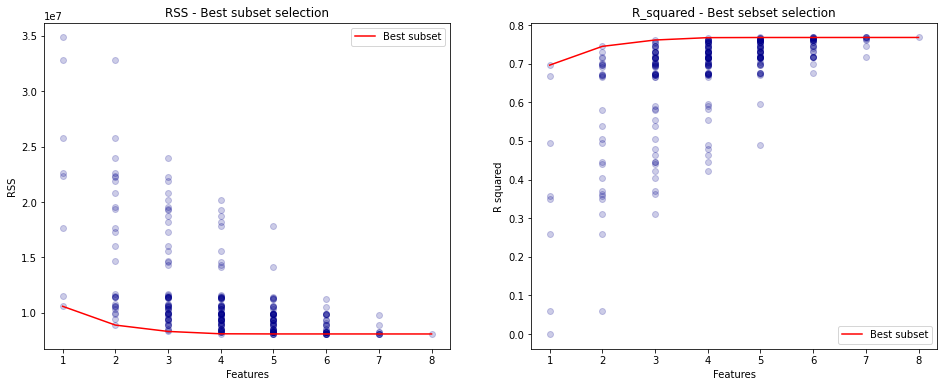

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(quant_reg_result.numb_features, quant_reg_result.RSS, alpha=.2, color="darkblue")
ax[0].plot(quant_reg_result.numb_features, quant_reg_result.min_RSS, color='r', label="Best subset")

ax[0].set_xlabel("Features")
ax[0].set_ylabel("RSS")
ax[0].set_title("RSS - Best subset selection")
ax[0].legend()

ax[1].scatter(quant_reg_result.numb_features, quant_reg_result.R_squared, alpha=.2, color="darkblue")
ax[1].plot(quant_reg_result.numb_features, quant_reg_result.max_R_squared, color='r', label="Best subset")

ax[1].set_xlabel("Features")
ax[1].set_ylabel("R squared")
ax[1].set_title("R_squared - Best sebset selection")
ax[1].legend()

plt.show()

어째 넣으면 넣을수록 맞지 않다. 하나(Hour_mean)만 넣어야 겠다.

## 예측

### 1. QuantReg를 이용

- QuantReg가 Linear Regression이랑 중간 구성이 다를 것으로 예상되어 여러 가정을 위배하는 듯 보인다.

In [128]:
quant_reg_sub = sub.copy()

for i in np.arange(0.1, 1, 0.1):
    s = "quant_reg_sub['q_%.1f'] = QuantReg(train.TARGET_2, quant_reg_train.Hour_mean).fit(q=%f).predict(quant_reg_test.Hour_mean)" % (i, i)
    exec(s)

# quant_reg_sub.to_csv("linear_regression.csv", index=False)

In [129]:
quant_reg_sub.head()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
rf_sub = sub.copy()

for i in np.arange(0.1, 1, 0.1):
    s = "rf_sub['q_%.1f'] = np.percentile(rf_result, %f)" % (i, i * 100)
    exec(s)

# rf_sub.to_csv("random_forest.csv", index=False)

In [133]:
rf_sub.head()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,1.641184,14.127665,29.762636,42.035892,57.551741
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,1.641184,14.127665,29.762636,42.035892,57.551741
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,1.641184,14.127665,29.762636,42.035892,57.551741
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,1.641184,14.127665,29.762636,42.035892,57.551741
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,1.641184,14.127665,29.762636,42.035892,57.551741
